In [19]:
import os
from PIL import Image
import numpy as np
from itertools import chain

import math

import pandas as pd
import torch
from torch.optim import Adam
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import xml.etree.ElementTree as ET

In [20]:
def create_image_annotation_table(image_dir, annotation_dir):
    image_files = os.listdir(image_dir)

    data = []

    for image_file in image_files:
        base_name, _ = os.path.splitext(image_file)
        annotation_file = os.path.join(annotation_dir, f"{base_name}.xml")
        tree = ET.parse(annotation_file)
        root = tree.getroot()

        annotation_data = ""
        for obj in root.findall('object'):
            char = obj.find('name').text
            annotation_data += char

        image_path = os.path.join(image_dir, image_file)
        data.append({'Image path': image_path, 'Annotation': annotation_data})

    return data

image_dir = "./car_plate_dataset/LP-characters/images/"
annotation_dir = "./car_plate_dataset/LP-characters/annotations/"
data = create_image_annotation_table(image_dir, annotation_dir)
print(data)

def split_dataset(data_dictionary):
    
    df = pd.DataFrame(data_dictionary)
    filename = "image_annotations_table.csv"
    file = df.to_csv(filename, index=False)
    read_filename = pd.read_csv(filename)

    
    print("total images:",len(read_filename))
    randomized_data = read_filename.sample(frac=1, random_state=42)
    print("total randomized images:",len(randomized_data))

    train = int(len(randomized_data) * 0.8)

    train_data = randomized_data[:train]
    print("total training set:",len(train_data))

    test_data = randomized_data[train:]
    print("total testing set:",len(test_data))

    train_filepath = "train_dataset.csv"
    test_filepath = "test_dataset.csv"
    train_data.to_csv(train_filepath, index=False)
    test_data.to_csv(test_filepath, index=False)

[{'Image path': './car_plate_dataset/LP-characters/images/0001.png', 'Annotation': 'MH02CB4545'}, {'Image path': './car_plate_dataset/LP-characters/images/0000.png', 'Annotation': 'MH15TC554'}, {'Image path': './car_plate_dataset/LP-characters/images/0003.png', 'Annotation': 'KA031351'}, {'Image path': './car_plate_dataset/LP-characters/images/0006.png', 'Annotation': 'HR696969'}, {'Image path': './car_plate_dataset/LP-characters/images/0004.png', 'Annotation': 'TN0600000'}, {'Image path': './car_plate_dataset/LP-characters/images/0005.png', 'Annotation': 'KA51MJ8156'}, {'Image path': './car_plate_dataset/LP-characters/images/0008.png', 'Annotation': 'TN07BU5427'}, {'Image path': './car_plate_dataset/LP-characters/images/0009.png', 'Annotation': 'GJ05443'}, {'Image path': './car_plate_dataset/LP-characters/images/0010.png', 'Annotation': 'KL55R2473'}, {'Image path': './car_plate_dataset/LP-characters/images/0012.png', 'Annotation': 'MH20CS1941'}, {'Image path': './car_plate_dataset/LP-

In [21]:
split_dataset(data_dictionary=data)

df = pd.read_csv("train_dataset.csv")
# print(df)

total images: 209
total randomized images: 209
total training set: 167
total testing set: 42


In [22]:
class CarPlateDataset(Dataset):
    def __init__(self, csv_file, size):
        super(CarPlateDataset, self).__init__()
        self.file = pd.read_csv(csv_file)
        self.labels = self.file['Annotation']
        self.image_paths = self.file['Image path']
        self.images = self.file['Image path'].tolist()
        self.image_size = size
        self.nSamples = len(self.images)
        transform_list = [
            transforms.Grayscale(1),
            transforms.Resize(self.image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ]
        self.transform = transforms.Compose(transform_list)
        self.collate_fn = CarPlateCollator()

    def __len__(self):
        return self.nSamples

    def __getitem__(self, index):
        assert index < len(self), 'index range error'
        imagepath = self.image_paths[index]
        img = Image.open(imagepath)
        if self.transform is not None:
            img = self.transform(img)
        label = self.labels[index]

        item = {'img': img, 'idx': index, 'label': label}
        return item

In [23]:
class CarPlateCollator(object):
    
    def __call__(self, batch):
        width = [item['img'].shape[2] for item in batch]
        indexes = [item['idx'] for item in batch]
        imgs = torch.ones([len(batch), batch[0]['img'].shape[0], batch[0]['img'].shape[1], 
                           max(width)], dtype=torch.float32)
        for idx, item in enumerate(batch):
            try:
                imgs[idx, :, :, 0:item['img'].shape[2]] = item['img']
            except:
                print(imgs.shape)
        item = {'img': imgs, 'idx':indexes}
        if 'label' in batch[0].keys():
            labels = [item['label'] for item in batch]
            item['label'] = labels
        return item

In [24]:
image_size = (32, 168)
train_dataset = CarPlateDataset('train_dataset.csv', size=image_size)
train_dataset = CarPlateDataset('test_dataset.csv', size=image_size)

Image label: MH14EU3498


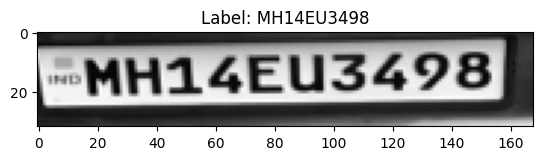

In [26]:
#checking if dataset works correctly

import matplotlib.pyplot as plt

for index in range(len(train_dataset)):
    labels = train_dataset.labels[index]
    item = train_dataset[index]

    img = item['img']

    label = item['label']
    print("Image label:", label)

    plt.imshow(img.squeeze().numpy(), cmap='gray')
    plt.title(f"Label: {label}")
    plt.show()
    break

In [27]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()
        self.rnn = nn.GRU(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)
        # self.dropout = nn.Dropout(0.1)
    def forward(self, input):
        self.rnn.flatten_parameters()
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)
        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)
        return output

class CRNN(nn.Module):

    def __init__(self, opt, leakyRelu=False):
        super(CRNN, self).__init__()

        assert opt['imgH'] % 16 == 0, 'imgH has to be a multiple of 16'

        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = opt['nChannels'] if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        convRelu(6, True)  # 512x1x16
        # cnn.add_module('pooling{0}'.format(4),
        #                nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        # convRelu(6, True)  # 512x1x16
        self.cnn = cnn
        self.rnn = nn.Sequential()
        self.rnn = nn.Sequential(
            BidirectionalLSTM(opt['nHidden']*2, opt['nHidden'], opt['nHidden']),
            BidirectionalLSTM(opt['nHidden'], opt['nHidden'], opt['nClasses']))


    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        # print(f"Conv1 output shape: {conv.shape}")
        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        # print(f"Conv2 output shape: {conv.shape}")
        conv = conv.permute(2, 0, 1)  # [w, b, c]
        # rnn features
        output = self.rnn(conv)
        output = output.transpose(1,0) #Tbh to bth
        return output

In [28]:
class CustomCTCLoss(torch.nn.Module):
    # T x B x H => Softmax on dimension 2
    def __init__(self, dim=2):
        super().__init__()
        self.dim = dim
        self.ctc_loss = torch.nn.CTCLoss(reduction='mean', zero_infinity=True)

    def forward(self, logits, labels,
            prediction_sizes, target_sizes):
        EPS = 1e-7
        loss = self.ctc_loss(logits, labels, prediction_sizes, target_sizes)
        loss = self.sanitize(loss)
        return self.debug(loss, logits, labels, prediction_sizes, target_sizes)
    
    def sanitize(self, loss):
        EPS = 1e-7
        if abs(loss.item() - float('inf')) < EPS:
            return torch.zeros_like(loss)
        if math.isnan(loss.item()):
            return torch.zeros_like(loss)
        return loss

    def debug(self, loss, logits, labels,
            prediction_sizes, target_sizes):
        if math.isnan(loss.item()):
            print("Loss:", loss)
            print("logits:", logits)
            print("labels:", labels)
            print("prediction_sizes:", prediction_sizes)
            print("target_sizes:", target_sizes)
            raise Exception("NaN loss obtained. But why?")
        return loss

In [29]:
from collections import OrderedDict
import logging

from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from torch.nn.utils.clip_grad import clip_grad_norm_
from torch.utils.data import random_split

from src.utils.utils import AverageMeter, Eval, OCRLabelConverter
from src.utils.utils import EarlyStopping, gmkdir
from src.optim.optimizer import STLR
from src.utils.utils import gaussian
from tqdm import *

In [30]:
class OCRTrainer(object):
    def __init__(self, opt):
        super(OCRTrainer, self).__init__()
        self.data_train = opt['data_train']
        self.data_val = opt['data_val']
        self.model = opt['model']
        self.criterion = opt['criterion']
        self.optimizer = opt['optimizer']
        self.schedule = opt['schedule']
        self.converter = OCRLabelConverter(opt['alphabet'])
        self.evaluator = Eval()
        print('Scheduling is {}'.format(self.schedule))
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=opt['epochs'])
        self.batch_size = opt['batch_size']
        self.count = opt['epoch']
        self.epochs = opt['epochs']
        self.cuda = opt['cuda']
        self.collate_fn = opt['collate_fn']
        self.init_meters()

    def init_meters(self):
        self.avgTrainLoss = AverageMeter("Train loss")
        self.avgTrainCharAccuracy = AverageMeter("Train Character Accuracy")
        self.avgTrainWordAccuracy = AverageMeter("Train Word Accuracy")
        self.avgValLoss = AverageMeter("Validation loss")
        self.avgValCharAccuracy = AverageMeter("Validation Character Accuracy")
        self.avgValWordAccuracy = AverageMeter("Validation Word Accuracy")

    def forward(self, x):
        logits = self.model(x)
        return logits.transpose(1, 0)

    def loss_fn(self, logits, targets, pred_sizes, target_sizes):
        loss = self.criterion(logits, targets, pred_sizes, target_sizes)
        return loss

    def step(self):
        self.max_grad_norm = 0.05
        clip_grad_norm_(self.model.parameters(), self.max_grad_norm)
        self.optimizer.step()
    
    def schedule_lr(self):
        if self.schedule:
            self.scheduler.step()

    def _run_batch(self, batch, report_accuracy=False, validation=False):
        input_, targets = batch['img'], batch['label']
        targets, lengths = self.converter.encode(targets)
        logits = self.forward(input_)
        logits = logits.contiguous().cpu()
        logits = torch.nn.functional.log_softmax(logits, 2)
        T, B, H = logits.size()
        pred_sizes = torch.LongTensor([T for i in range(B)])
        targets= targets.view(-1).contiguous()
        loss = self.loss_fn(logits, targets, pred_sizes, lengths)
        if report_accuracy:
            probs, preds = logits.max(2)
            preds = preds.transpose(1, 0).contiguous().view(-1)
            sim_preds = self.converter.decode(preds.data, pred_sizes.data, raw=False)
            ca = np.mean((list(map(self.evaluator.char_accuracy, list(zip(sim_preds, batch['label']))))))
            wa = np.mean((list(map(self.evaluator.word_accuracy, list(zip(sim_preds, batch['label']))))))
        return loss, ca, wa

    def run_epoch(self, validation=False):
        if not validation:
            loader = self.train_dataloader()
            pbar = tqdm(loader, desc='Epoch: [%d]/[%d] Training'%(self.count, 
                self.epochs), leave=True)
            self.model.train()
        else:
            loader = self.val_dataloader()
            pbar = tqdm(loader, desc='Validating', leave=True)
            self.model.eval()
        outputs = []
        for batch_nb, batch in enumerate(pbar):
            if not validation:
                output = self.training_step(batch)
            else:
                output = self.validation_step(batch)
            pbar.set_postfix(output)
            outputs.append(output)
        self.schedule_lr()
        if not validation:
            result = self.train_end(outputs)
        else:
            result = self.validation_end(outputs)
        return result

    def training_step(self, batch):
        loss, ca, wa = self._run_batch(batch, report_accuracy=True)
        self.optimizer.zero_grad()
        loss.backward()
        self.step()
        output = OrderedDict({
            'loss': abs(loss.item()),
            'train_ca': ca.item(),
            'train_wa': wa.item()
            })
        return output

    def validation_step(self, batch):
        loss, ca, wa = self._run_batch(batch, report_accuracy=True, validation=True)
        output = OrderedDict({
            'val_loss': abs(loss.item()),
            'val_ca': ca.item(),
            'val_wa': wa.item()
            })
        return output

    def train_dataloader(self):
        # logging.info('training data loader called')
        loader = torch.utils.data.DataLoader(self.data_train,
                batch_size=self.batch_size,
                collate_fn=self.collate_fn,
                shuffle=True)
        return loader
        
    def val_dataloader(self):
        # logging.info('val data loader called')
        loader = torch.utils.data.DataLoader(self.data_val,
                batch_size=self.batch_size,
                collate_fn=self.collate_fn)
        return loader

    def train_end(self, outputs):
        for output in outputs:
            self.avgTrainLoss.add(output['loss'])
            self.avgTrainCharAccuracy.add(output['train_ca'])
            self.avgTrainWordAccuracy.add(output['train_wa'])

        train_loss_mean = abs(self.avgTrainLoss.compute())
        train_ca_mean = self.avgTrainCharAccuracy.compute()
        train_wa_mean = self.avgTrainWordAccuracy.compute()

        result = {'train_loss': train_loss_mean, 'train_ca': train_ca_mean,
        'train_wa': train_wa_mean}
        # result = {'progress_bar': tqdm_dict, 'log': tqdm_dict, 'val_loss': train_loss_mean}
        return result

    def validation_end(self, outputs):
        for output in outputs:
            self.avgValLoss.add(output['val_loss'])
            self.avgValCharAccuracy.add(output['val_ca'])
            self.avgValWordAccuracy.add(output['val_wa'])

        val_loss_mean = abs(self.avgValLoss.compute())
        val_ca_mean = self.avgValCharAccuracy.compute()
        val_wa_mean = self.avgValWordAccuracy.compute()

        result = {'val_loss': val_loss_mean, 'val_ca': val_ca_mean,
        'val_wa': val_wa_mean}
        return result

In [31]:
class Learner(object):
    def __init__(self, model, optimizer, savepath=None, resume=False):
        self.model = model
        self.optimizer = optimizer
        self.savepath = os.path.join(savepath, 'best.ckpt')
        self.cuda = torch.cuda.is_available() 
        self.cuda_count = torch.cuda.device_count()
        if self.cuda:
            self.model = self.model.cuda()
        self.epoch = 0
        if self.cuda_count > 1:
            print("Let's use", torch.cuda.device_count(), "GPUs!")
            self.model = nn.DataParallel(self.model)
        self.best_score = None
        if resume and os.path.exists(self.savepath):
            self.checkpoint = torch.load(self.savepath)
            self.epoch = self.checkpoint['epoch']
            self.best_score=self.checkpoint['best']
            self.load()
        else:
            print('checkpoint does not exist')

    def fit(self, opt):
        opt['cuda'] = self.cuda
        opt['model'] = self.model
        opt['optimizer'] = self.optimizer
        logging.basicConfig(filename="%s/%s.csv" %(opt['log_dir'], opt['name']), level=logging.INFO)
        self.saver = EarlyStopping(self.savepath, patience=15, verbose=True, best_score=self.best_score)
        opt['epoch'] = self.epoch
        trainer = OCRTrainer(opt)
        
        for epoch in range(opt['epoch'], opt['epochs']):
            train_result = trainer.run_epoch()
            val_result = trainer.run_epoch(validation=True)
            trainer.count = epoch
            info = '%d, %.6f, %.6f, %.6f, %.6f, %.6f, %.6f'%(epoch, train_result['train_loss'], 
                val_result['val_loss'], train_result['train_ca'],  val_result['val_ca'],
                train_result['train_wa'], val_result['val_wa'])
            logging.info(info)
            self.val_loss = val_result['val_loss']
            print(self.val_loss)
            if self.savepath:
                self.save(epoch)
            if self.saver.early_stop:
                print("Early stopping")
                break

    def load(self):
        print('Loading checkpoint at {} trained for {} epochs'.format(self.savepath, self.checkpoint['epoch']))
        self.model.load_state_dict(self.checkpoint['state_dict'])
        if 'opt_state_dict' in self.checkpoint.keys():
            print('Loading optimizer')
            self.optimizer.load_state_dict(self.checkpoint['opt_state_dict'])

    def save(self, epoch):
        self.saver(self.val_loss, epoch, self.model, self.optimizer)

In [35]:
ocr_characters = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 -"
args = {
    'size': (32, 192),
    'name':'exp1',
    'path':'data',
    'imgdir': train_dataset.images,
    'imgH':32,
    'nChannels':1,
    'nHidden':256,
    'nClasses':len(ocr_characters),
    'lr':0.001,
    'epochs':4,
    'batch_size':2,
    'save_dir':'checkpoints_Cars',
    'log_dir':'logs',
    'resume':False,
    'cuda':False,
    'schedule':False
}

data =  CarPlateDataset('train_dataset.csv', size=image_size)
args['collate_fn'] = CarPlateCollator()
train_split = int(0.8*len(data))
val_split = len(data) - train_split
args['data_train'], args['data_val'] = random_split(data, (train_split, val_split))
print('Traininig Data Size:{}\nVal Data Size:{}'.format(
    len(args['data_train']), len(args['data_val'])))
args['alphabet'] = ocr_characters
model = CRNN(args)
args['criterion'] = CustomCTCLoss()
savepath = os.path.join(args['save_dir'], args['name'])
# gmkdir(savepath)
# gmkdir(args['log_dir'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
learner = Learner(model, optimizer, savepath=savepath, resume=args['resume'])
learner.fit(args)

Traininig Data Size:133
Val Data Size:34
Let's use 4 GPUs!
checkpoint does not exist
None
Scheduling is False


Validating: 100%|██████████| 17/17 [00:00<00:00, 53.08it/s, val_loss=3.44, val_ca=10, val_wa=0]  


3.2675437506507423
Validation loss decreased (inf --> 3.267544).  Saving model ...


Validating: 100%|██████████| 17/17 [00:00<00:00, 52.34it/s, val_loss=3.69, val_ca=5, val_wa=0]  


3.2134393453598022
Validation loss decreased (3.267544 --> 3.213439).  Saving model ...


Validating: 100%|██████████| 17/17 [00:00<00:00, 51.57it/s, val_loss=2.81, val_ca=10, val_wa=0] 


3.1019190526476095
Validation loss decreased (3.213439 --> 3.101919).  Saving model ...


Validating: 100%|██████████| 17/17 [00:00<00:00, 53.22it/s, val_loss=3.01, val_ca=27.5, val_wa=0]


3.0220571405747356
Validation loss decreased (3.101919 --> 3.022057).  Saving model ...


In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def get_accuracy(args):
    loader = DataLoader(args['data'],
                batch_size=args['batch_size'],
                collate_fn=args['collate_fn'])
    model = args['model']
    model.eval()
    converter = OCRLabelConverter(args['alphabet'])
    evaluator = Eval()
    labels, predictions, images = [], [], []
    for iteration, batch in enumerate(tqdm(loader)):
        input_, targets = batch['img'].to(device), batch['label']
        images.extend(input_.squeeze().detach())
        labels.extend(targets)
        targets, lengths = converter.encode(targets)
        logits = model(input_).transpose(1, 0)
        logits = torch.nn.functional.log_softmax(logits, 2)
        logits = logits.contiguous().cpu()
        T, B, H = logits.size()
        pred_sizes = torch.LongTensor([T for i in range(B)])
        probs, pos = logits.max(2)
        pos = pos.transpose(1, 0).contiguous().view(-1)
        sim_preds = converter.decode(pos.data, pred_sizes.data, raw=False)
        predictions.extend(sim_preds)
        
#     make_grid(images[:10], nrow=2)
    fig=plt.figure(figsize=(8, 8))
    columns = 4
    rows = 5
    for i in range(1, columns*rows +1):
        img = images[i].cpu()
        img = (img - img.min())/(img.max() - img.min())
        img = np.array(img * 255.0, dtype=np.uint8)
        fig.add_subplot(rows, columns, i)
        plt.title(predictions[i])
        plt.axis('off')
        plt.imshow(img)
    plt.show()
    ca = np.mean((list(map(evaluator.char_accuracy, list(zip(predictions, labels))))))
    wa = np.mean((list(map(evaluator.word_accuracy_line, list(zip(predictions, labels))))))
    return ca, wa, predictions, labels

def get_precision_recall(preds, labels):
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    for pred, label in zip(preds, labels):
        pred_tokens = pred.split() 
        label_tokens = label.split() 

        true_positives += len(set(pred_tokens) & set(label_tokens))
        false_positives += len(set(pred_tokens) - set(label_tokens))
        false_negatives += len(set(label_tokens) - set(pred_tokens))

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)

    return precision, recall

Loading model checkpoints_Cars/exp6/best.ckpt


100%|██████████| 21/21 [00:00<00:00, 50.43it/s]


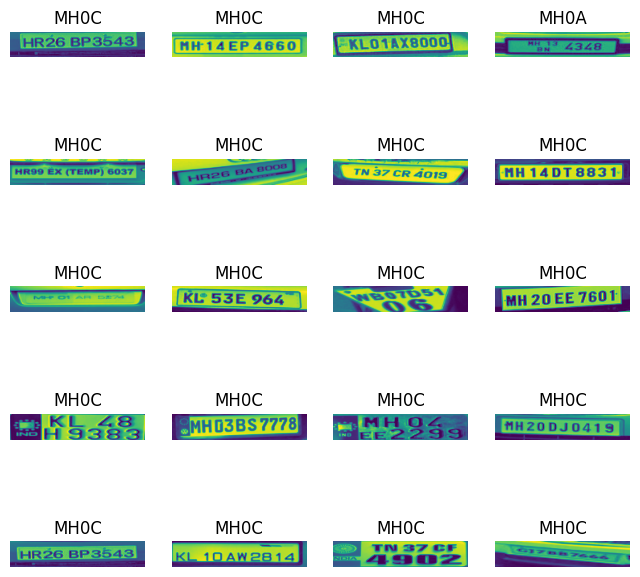

Character Accuracy: 15.25
Word Accuracy: 0.00
Precision: 0.00
Recall: 0.00
['MH0C', 'MH0C', 'MH0C', 'MH0C', 'MH0A', 'MH0C', 'MH0C', 'MH0C', 'MH0C', 'MH0C', 'MH0C', 'MH0C', 'MH0C', 'MH0C', 'MH0C', 'MH0C', 'MH0C', 'MH0C', 'MH0C', 'MH0C', 'MH0C', 'MH0C', 'MH0C', 'MH0C', 'MH0C', 'MH0C', 'MH0', 'MH0C', 'MH0C', 'MH0C', 'MH0C', 'MH0C', 'MH0C', 'MH0C', 'MH0C', 'MH0C', 'MH0C', 'MH0C', 'MH0C', 'MH0C', 'MH0C', 'MH0C']
['MH14EU3498', 'HR26BP3543', 'MH14EP4660', 'KL01AX8000', 'MH13BN4348', 'HR99EXTEMP6037', 'HR26BA8008', 'TN37CR4019', 'MH14DT8831', 'MH01AR5274', 'KL53E964', 'WB07D5106', 'MH20EE7601', 'KL48H9383', 'MH03BS7778', 'MH04EE2299', 'MH20DJ0419', 'HR26BP3543', 'KL10AWW814', 'TN37CF4902', 'GJ7BB7666', 'MH20BY3665', 'MH15TC554', 'KA51AA3469', 'GJ07BR1336', 'KL10AW2814', 'KL38F5008', 'TN42R2697', 'T0N2AH4432', 'AP02BP2454', 'MH20B4Y546', 'KL07CB8599', 'HR99HATEMP4575', 'MH14DT8831', 'MH03BS7778', 'MH14TCF460', 'KL06H5834', 'TS08ER1643', 'DL7CN5617', 'KL08BH6265', 'MH01AV8866', 'TN42R2697']


In [43]:
test_dataset = CarPlateDataset("test_dataset.csv", size=image_size)
args['imgdir'] = test_dataset.images
args['data'] = test_dataset
resume_file = os.path.join(args['save_dir'], args['name'], 'best.ckpt')
if os.path.isfile(resume_file):
    print('Loading model %s'%resume_file)
    checkpoint = torch.load(resume_file)
    model.load_state_dict(checkpoint['state_dict'], strict=False)
    args['model'] = model
    ca, wa, preds, labs = get_accuracy(args)
    precision, recall = get_precision_recall(preds, labs)
    print("Character Accuracy: %.2f\nWord Accuracy: %.2f"%(ca, wa))
    print("Precision: %.2f\nRecall: %.2f"%(precision, recall))
    print(preds)
    print(labs)
else:
    print("=> no checkpoint found at '{}'".format(save_file))
    print('Exiting')